# A1: Data Curation
Karl Stavem  
ID:  1978397

---
> TL;DR: The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1, 2008 through August 30, 2020.
---

### Step 1: Gathering the data

In [1]:
# import libraries
import os
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Since there are two separate APIs, define the endpoints.

In [2]:
# set the API endpoint

# from January 2008 to July 2016
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

# from May 1st, 2015
endpoint_new = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

First, make sure header information is set for each API call.

In [3]:
# set headers for API calls
headers = {
    'User-Agent': 'https://github.com/stavem',
    'From': 'kstavem@uw.edu'
}

Because the parameters are similiar in each API but the syntax is slightly different between them, create a method to quickly switch between the two.   For this exercise, most of our parameters remain constant so we only need to change the version and access site.  We could also leave the start and end date constant if we like to catch all possible data in each API.

In [4]:
def assign_parameters(is_legacy_version, access, project = "en.wikipedia.org", agent = "user", granularity = "monthly", 
                      start = '2008010100', end =  '2020090100'):
    """
    Input:  Access and is_legacy_version
            For legacy API set is_legacy_version = 1
            For legacy API:  Valid access inputs in ['dektop-site', 'mobile-site']
            For non-legacy API:  Valid access in ['desktop', 'mobile-web', 'mobile-app']
        
    Output:  Parameters for use in API query
    """
    
    if is_legacy_version:
                      params = {"project" : project,
                                "access-site" : access,
                                "granularity" : granularity,
                                "start" : start,
                                "end" : end
                               }

    else:
                      params = {"project" : project,
                                "access" :access,
                                "agent" : agent,
                                "granularity" : granularity,
                                "start" : start,
                                "end" : end
                               }
    return params

Create a method to pass these parameters into a wikipedia API call and return the response.

In [5]:
def api_call(endpoint,parameters):
    """
    Conduct API calls
    Inputs:  Wikipedia API Endpoint, Parameters for API call
    Output:  Response in JSON format
    """
    
    # try to call the api
    try:
        call = requests.get(endpoint.format(**parameters), headers=headers)
        call.raise_for_status()
        
    # Alert user of any errors
    except requests.exceptions.HTTPError as error:
        print(error)
    
    response = call.json()
    return response

In [6]:
# define the 5 sites we'll be looking at
new_sites = ['desktop', 'mobile-web', 'mobile-app']
legacy_sites = ['desktop-site', 'mobile-site']

In [7]:
# set directory to work with all saved files
directory_path = '/home/jovyan/data-512/data-512-a1/'

# store list of saved files for later
files_list = []

Collect all 3 data sources from the new API.   Save the results as JSON files.  Store the file names in a list for access later.

In [8]:
for site in new_sites:
    
    # call the API
    params = assign_parameters(is_legacy_version = 0, access = site, start = '2015070100', end = '2020080100')
    data = api_call(endpoint_new, params)
    
    # name the file, store location in a list
    filename = 'pageviews_{}_201507-202008.json'.format(site)
    files_list.append(directory_path + filename)
    
    # write to file
    with open(directory_path + filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    
    

Collect all 3 data sources from the legacy API.   Save the results as JSON files.  Store the file names in a list for access later.

In [9]:
for site in legacy_sites:
    
    # call the API
    params = assign_parameters(is_legacy_version = 1, access = site, start = '2007120100', end = '2016080100')
    data = api_call(endpoint_legacy, params)
    
    # name the file, store location in a list
    filename = 'legacy_pagecounts_{}_200712-201607.json'.format(site)
    files_list.append(directory_path + filename)
    
    # write to file
    with open(directory_path + filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


### Step 2: Processing the data

* For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.

First, iterate through all the files that have been collected and combine them into one big JSON file.

In [12]:
# combine all json files into one json file
combined_json_file=[]

for file in files_list:
    with open(file) as f:
        combined_json_file.append(json.load(f))

Then, convert that JSON file into a data frame to make it easier to manipulate.

In [13]:
# convert JSON file into pandas dataframe
df = pd.DataFrame()
for i in range(len(combined_json_file)):
    df=df.append(pd.json_normalize(combined_json_file[i]['items']))                      

In [ ]:
# # keep track of the api that was used
# df['API'] = np.where(df['access'].isna(), 'pagecount', 'pageviews')

In [14]:
# drop the project, granularity columns - unnecessary
df.drop(['project', 'granularity', 'agent'], axis=1, inplace = True)


Rename some of the date to make aggregation easier

In [15]:
# combine all the newest mobile traffic into one category
df.loc[df['access'].isin(['mobile-app', 'mobile-web']),'access'] = 'pageview_mobile_views'

# change the desktop value
df.loc[df['access'].isin(['desktop']),'access'] = 'pageview_desktop_views'

# combine all the newest mobile traffic into one category
df.loc[df['access-site'].isin(['mobile-site']),'access-site'] = 'pagecount_mobile_views'

# change the value to desktop to desktop-site
df.loc[df['access-site'].isin(['desktop-site']),'access-site'] = 'pagecount_desktop_views'


In [16]:
# # create a new source column to track
df['source'] = np.where(df["access"].isnull(), df["access-site"], df["access"] )

# #drop old columns
df.drop(['access', 'access-site'], axis=1, inplace = True)

In [17]:
# extract the year and the month from the timestamp column
df['year'] = df['timestamp'].str[:4]
df['month'] = df['timestamp'].str[4:6]

# drop the timestamp column as it is unnecessary
df.drop(['timestamp'], axis=1, inplace = True)


In [18]:
# get rid of NA in total columns
df['views'] = df['views'].fillna(0)
df['count'] = df['count'].fillna(0)

# add totals
df['views'] = df['views']+df['count'].fillna(0)

# drop the count column
df.drop(['count'], axis=1, inplace = True)

Combine all data into a single CSV file with the following headers:

* year / YYYY
* month / MM
* pagecount_all_views / num_views
* pagecount_desktop_views / num_views
* pagecount_mobile_views / num_views
* pageview_all_views / num_views
* pageview_desktop_views / num_views
* pageview_mobile_views / num_views


In [19]:
# pivot the data and aggregate according the the instructions

df_pivoted = pd.pivot_table(df, values='views', index=['year', 'month'],
                    columns=['source'], aggfunc=np.sum, fill_value=0)

# Formatting.
df_pivoted.reset_index(inplace=True)
df_pivoted.columns.name = None

In [20]:
# add all traffic for totals
df_pivoted['pagecount_all_views'] = df_pivoted['pagecount_desktop_views'] + df_pivoted['pagecount_mobile_views']
df_pivoted['pageview_all_views'] = df_pivoted['pageview_desktop_views'] + df_pivoted['pageview_mobile_views']

In [26]:
# view results
df_pivoted

,year,month,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,pagecount_all_views,pageview_all_views
0,2007,12,2998331524,0,0,0,2998331524,0
1,2008,01,4930902570,0,0,0,4930902570,0
2,2008,02,4818393763,0,0,0,4818393763,0
3,2008,03,4955405809,0,0,0,4955405809,0
4,2008,04,5159162183,0,0,0,5159162183,0
...,...,...,...,...,...,...,...,...
147,2020,03,0,0,3412498274,4686270555,0,8098768829
148,2020,04,0,0,3798372613,5505741941,0,9304114554
149,2020,05,0,0,3078093615,5231700095,0,8309793710
150,2020,06,0,0,2721328557,4573975256,0,7295303813


In [21]:
# rearrange columns and order to match assignment
df = df_pivoted[['year','month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
                'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']].sort_values(by=['year', 'month'])
df

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2998331524,2998331524,0,0,0,0
1,2008,01,4930902570,4930902570,0,0,0,0
2,2008,02,4818393763,4818393763,0,0,0,0
3,2008,03,4955405809,4955405809,0,0,0,0
4,2008,04,5159162183,5159162183,0,0,0,0
...,...,...,...,...,...,...,...,...
147,2020,03,0,0,0,8098768829,3412498274,4686270555
148,2020,04,0,0,0,9304114554,3798372613,5505741941
149,2020,05,0,0,0,8309793710,3078093615,5231700095
150,2020,06,0,0,0,7295303813,2721328557,4573975256


For all months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app), that value for that (column, month) should be listed as 0. So for example all values of pagecount_mobile_views for months before October 2014 should be 0, because mobile traffic data is not available before that month.

In [41]:
df['year']

0      2007
1      2008
2      2008
3      2008
4      2008
       ... 
147    2020
148    2020
149    2020
150    2020
151    2020
Name: year, Length: 152, dtype: object

The final data file should be named: `en-wikipedia_traffic_200712-202008.csv`

In [23]:
# write file
df.to_csv('en-wikipedia_traffic_200712-202008.csv', index=False)

### Step 3: Analyze the data

In [48]:
# Using matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# magic code for viewing plots using jupyter notebooks:
%matplotlib inline 

In [136]:
df[df.index > '2015-05-01'][['pageview_desktop_views']+['pagecount_desktop_views']]/1000000

,pageview_desktop_views,pagecount_desktop_views
2015-06-01,0.000000,5165.413640
2015-07-01,4376.666686,5229.226022
2015-08-01,4332.482183,5035.534449
2015-09-01,4485.491704,5409.631355
2015-10-01,4477.532755,5535.704471
...,...,...
2020-03-01,3412.498274,0.000000
2020-04-01,3798.372613,0.000000
2020-05-01,3078.093615,0.000000
2020-06-01,2721.328557,0.000000


In [131]:
df[df.index > '2015-05-01']

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
2015-06-01,2015,06,8203576103,5165413640,3038162463,0,0,0
2015-07-01,2015,07,8483698717,5229226022,3254472695,7665421980,4376666686,3288755294
2015-08-01,2015,08,8304022031,5035534449,3268487582,7634815221,4332482183,3302333038
2015-09-01,2015,09,8582061182,5409631355,3172429827,7655695037,4485491704,3170203333
2015-10-01,2015,10,8781786976,5535704471,3246082505,7746031887,4477532755,3268499132
...,...,...,...,...,...,...,...,...
2020-03-01,2020,03,0,0,0,8098768829,3412498274,4686270555
2020-04-01,2020,04,0,0,0,9304114554,3798372613,5505741941
2020-05-01,2020,05,0,0,0,8309793710,3078093615,5231700095
2020-06-01,2020,06,0,0,0,7295303813,2721328557,4573975256


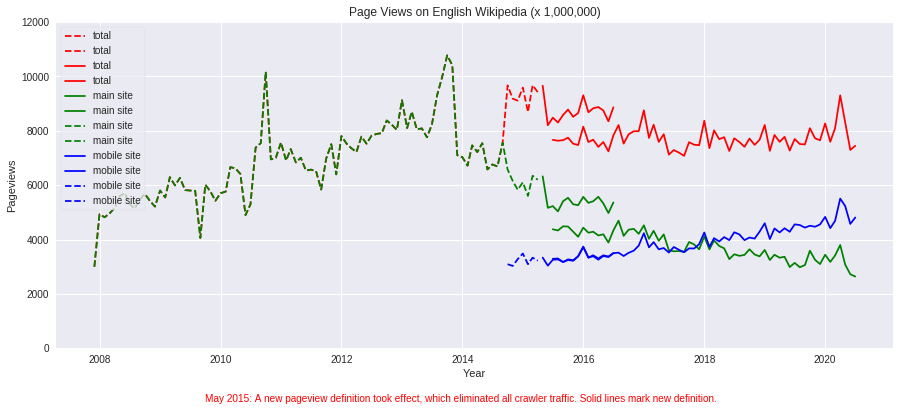

In [147]:
fig, ax = plt.subplots(figsize=(15, 6))

# Set plot title , axes labels/range
ax.set(title = "Page Views on English Wikipedia (x 1,000,000)")
ax.set(xlabel = "Year")
ax.set(ylabel = "Pageviews")
plt.ylim(0,12000)

# write the caption at the bottom of the page
caption = 'May 2015: A new pageview definition took effect, which eliminated all crawler traffic.\
 Solid lines mark new definition.'

# add lines to the plot (divide by 1,000,000 for scale)
ax.plot((df[df.index < '2015-05-01'][['pagecount_all_views']+['pageview_all_views']]/1000000).where((df[['pagecount_all_views']+['pageview_all_views']]>0)), '--r', label='total')
ax.plot((df[df.index >= '2015-05-01'][['pagecount_all_views']+['pageview_all_views']]/1000000).where((df[['pagecount_all_views']+['pageview_all_views']]>0)), '-r', label='total')


ax.plot((df[df.index >= '2015-05-01'][['pageview_desktop_views']+['pagecount_desktop_views']]/1000000).where(df[['pageview_desktop_views']+['pagecount_desktop_views']]>0), '-g', label='main site')
ax.plot((df[df.index < '2015-05-01'][['pageview_desktop_views']+['pagecount_desktop_views']]/1000000).where(df[['pageview_desktop_views']+['pagecount_desktop_views']]>0), '--g', label='main site')


ax.plot((df[df.index >= '2015-05-01'][['pageview_mobile_views']+['pagecount_mobile_views']]/1000000).where(df[['pageview_mobile_views']+['pagecount_mobile_views']]>0), '-b', label='mobile site')
ax.plot((df[df.index < '2015-05-01'][['pageview_mobile_views']+['pagecount_mobile_views']]/1000000).where(df[['pageview_mobile_views']+['pagecount_mobile_views']]>0), '--b', label='mobile site')



# add caption and legend to figure
fig.text(.5, .001, caption, ha='center', c = 'r')
ax.legend(loc='upper left', frameon=True)
plt.show()

In [62]:
ax = df.set_index(pd.to_datetime(df[['year','month']].assign(day=1)))[['pageview_desktop_views']+['pagecount_desktop_views']].where(df[['pageview_desktop_views']+['pagecount_desktop_views']]>0)\
       .plot(color='b', figsize=(15,5.5), title='Monthly Data')
_ = ax.set_xlabel('Data')
_ = ax.set_ylabel('Data')

TypeError: Cannot broadcast np.ndarray with operand of type <class 'list'>

In [38]:
np.where(df['pageview_desktop_views']+df['pagecount_desktop_views'] > 0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151]),)

In [51]:
df = df.set_index(pd.to_datetime(df[['year','month']].assign(day=1)))

In [111]:
df.index < '2015-05-01'

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [45]:
plt = df.set_index(pd.to_datetime(df[['year','month']].assign(day=1)))

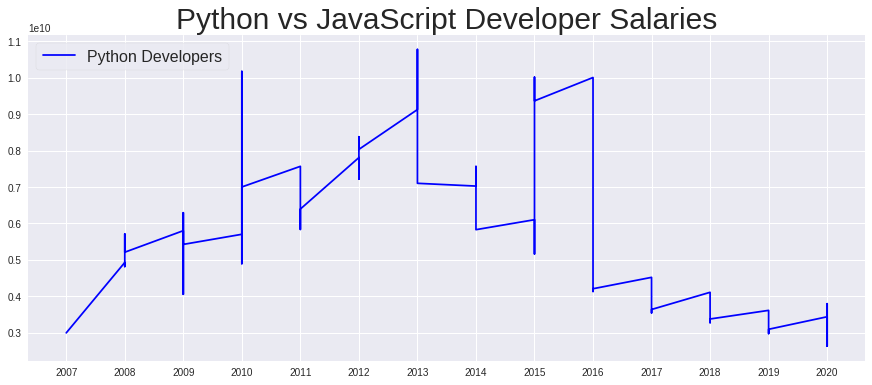

In [53]:
plt.style.use('seaborn')
fig=plt.figure(figsize = (15,6))

# x = df.set_index(pd.to_datetime(df[['year','month']].assign(day=1)))
# python = plt.plot('Python', data = df, color = 'forestgreen')
# plt.plot(df['pageview_desktop_views']+df['pagecount_desktop_views']/1000000, '--g', label='main site')

plt.plot(df.set_index(pd.to_datetime(df[['year','month']].assign(day=1)))['year'],df['pageview_desktop_views']+df['pagecount_desktop_views'].where(df['pageview_desktop_views']+df['pagecount_desktop_views'] > 0),c='b',label='line 2')
# javascript = plt.plot('JavaScript', data = df, color = 'darkorange')

plt.title('Python vs JavaScript Developer Salaries', size = 30)

# plt.xlabel('Age', size = 25)
# plt.xticks(size = 15)

# plt.ylabel('Salaries', size = 25)
# plt.yticks(size = 15)

plt.legend(labels = ['Python Developers', 'Line 2'], prop={"size":16}, loc='upper left', frameon=True);

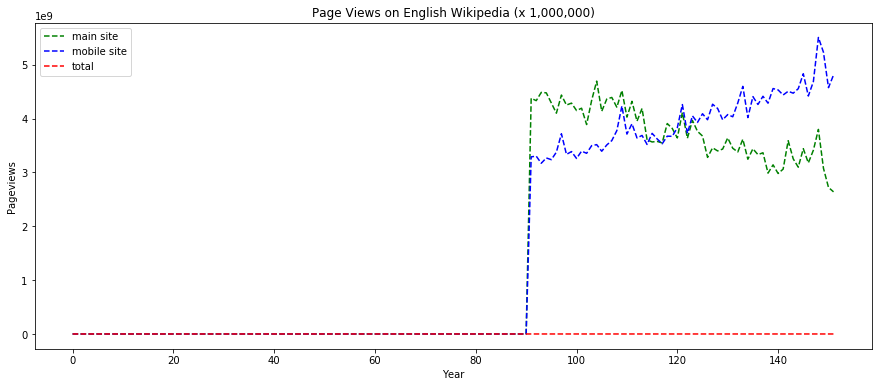

In [71]:

fig, ax = plt.subplots(figsize=(15, 6))
# Set plot title and axes labels
ax.set(title = "Page Views on English Wikipedia (x 1,000,000)",
       xlabel = "Year",
       ylabel = "Pageviews")
ax.plot(df['pageview_desktop_views']+df['pagecount_desktop_views']/1000000, '--g', label='main site')
ax.plot( df['pageview_mobile_views']+df['pagecount_mobile_views']/1000000, '--b', label='mobile site')
ax.plot(df['pagecount_all_views']/1000000, '--r', label='total')
ax.legend(loc='upper left', frameon=True);

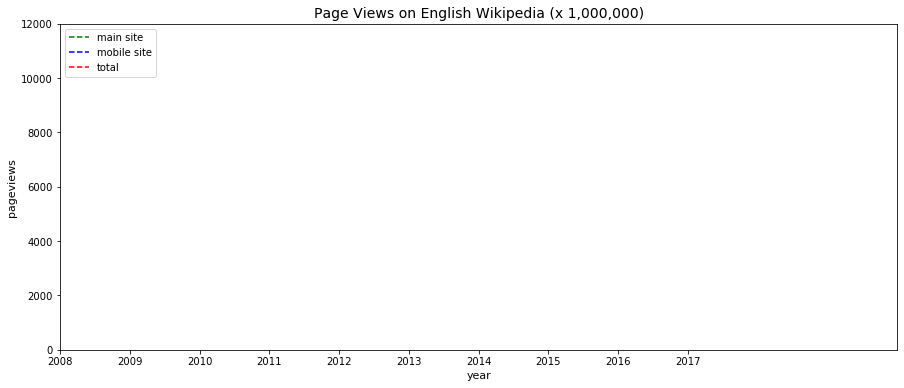

In [73]:
plt.figure(figsize=(15,6)) 

plt.plot((df['pageview_desktop_views']/1000000+df['pagecount_desktop_views']/1000000), '--g', label='main site') 
plt.plot(df['pageview_mobile_views']+df['pagecount_mobile_views'], '--b', label='mobile site') 
plt.plot(df['pagecount_all_views'], '--r', label='total')
# plt.scatter(np.where(record_2015_min < record_min.values),record_2015_min[record_2015_min < record_min].values,c='b',label='2015 break low')
# plt.scatter(np.where(record_2015_max > record_max.values),record_2015_max[record_2015_max > record_max].values,c='r',label='2015 break high') 
plt.xlabel('year',size=11) 
plt.ylabel('pageviews',size=11) 
plt.title('Page Views on English Wikipedia (x 1,000,000)', size = 14)
plt.xticks(np.arange(2008,2018,1), ['2008','2009', '2010','2011','2012','2013','2014','2015','2016','2017']) 
ax=plt.gca() 
ax.axis([2008,2020,0,12000]) 
# plt.gca().fill_between(np.arange(0,365),record_min, record_max,facecolor='blue',alpha=0.25) 
# plt.title('Record temperatures for different months between 2005-2014',size=14) 
plt.legend(loc='upper left', frameon=True) 
plt.show()

### Step 4: Document your process thoroughly

---
### Step 5: Submit the assignment

The github link for this assignment can be found here:   <a href="https://github.com/stavem/data-512/tree/main/data-512-a1">here</a>.

The github link for this assignment can be found here:   <a href="https://github.com/stavem/data-512/tree/main/data-512-a1">here</a>.